In [1]:
import s3fs
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })

In [3]:
fsg.ls('data/quiver-data')

['data/quiver-data/bathym.nc',
 'data/quiver-data/botvel.nc',
 'data/quiver-data/ubar.nc',
 'data/quiver-data/vbar.nc']

In [4]:
data_path = 's3://data/quiver-data/*.nc'

In [5]:
remote_files = fsg.glob(data_path)
remote_files

['data/quiver-data/bathym.nc',
 'data/quiver-data/botvel.nc',
 'data/quiver-data/ubar.nc',
 'data/quiver-data/vbar.nc']

In [11]:
fileset = [fsg.open(file) for file in remote_files]
#combine all datasets on coords
dset = xr.open_mfdataset(fileset, combine='by_coords', compat='override')
dset

<xarray.Dataset>
Dimensions:                        (depth: 75, x: 1580, y: 1801)
Coordinates:
    depthu                         (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    depthv                         (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lat                        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon                        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
  * depth                          (depth) float32 0.5058 1.556 ... 5.902e+03
    time_centered                  object ...
    time_counter                   object ...
Dimensions without coordinates: x, y
Data variables:
    __xarray_dataarray_variable__  (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    mbathy                         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty                       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx                       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [ ]:
# files needed 
v = xr.open_mfdataset(filedir + 'vbar.nc')
u = xr.open_mfdataset(filedir + 'ubar.nc')
bat = xr.open_mfdataset(filedir + '/CREG12.L75.script/bathym.nc')
dyp = xr.open_mfdataset(filedir + 'depth.nc')
cmap_r = plt.get_cmap("magma_r")


In [12]:
dset = dset.rename({'__xarray_dataarray_variable__' : 'botvel'})
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
    depthu         (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    depthv         (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
Dimensions without coordinates: x, y
Data variables:
    botvel         (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [13]:
# Velocity data 
u = dset.vozocrtx*73
v = dset.vomecrty*73
vel = (u**2 + v**2)**0.5

In [14]:
# Smoothening Velocity data
us = u.rolling(x=10).mean()
vs = v.rolling(y=10).mean()
vels = (us**2 + vs**2)**0.5


In [16]:
# Quiver

c = 15
N = 100

x = np.linspace(0, 1801, 1801)
dx = 20 
x.shape

y = np.linspace(0, 1580, 1580)
dy = 20
y.shape

X, Y = np.meshgrid(x, y)
print(X.shape)
print(us.shape)


(1580, 1801)
(75, 1801, 1580)


In [18]:
# chooseing a level to look at 
level = 15
depth = dset.depth[level].values
print(depth)

y_grid = np.array(Y.T[800:1800:dx, 200:1400:dy])
print(y_grid.shape)
x_grid = np.array(X.T[800:1800:dx, 200:1400:dy])
u_grid = np.array(us[level,800:1800:dx, 200:1400:dy].values)#endring
print(u_grid.shape)
v_grid = np.array(vs[level, 800:1800:dx, 200:1400:dy].values)
vel_grid = np.array(vels[level,800:1800:dx, 200:1400:dy].values)


35.740204
(50, 60)
(50, 60)


<ipython-input-20-a73c3b717981>:9: RuntimeWarning: invalid value encountered in true_divide
  u_grid/vel_grid,
<ipython-input-20-a73c3b717981>:10: RuntimeWarning: invalid value encountered in true_divide
  v_grid/vel_grid,


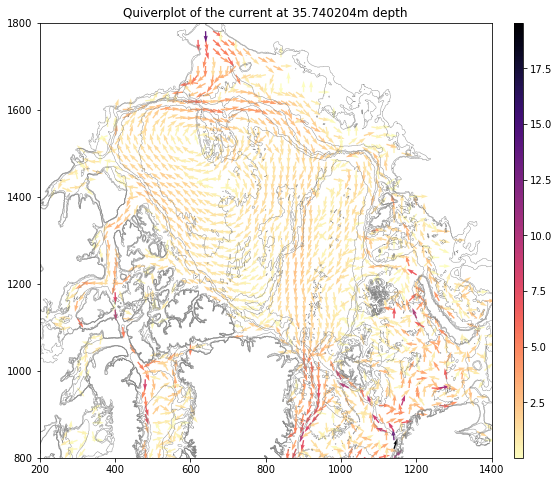

In [20]:
# plotting the quiver
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cmap_r = plt.get_cmap('magma_r')

ax.contour(dset.mbathy, colors='grey', levels=8, linewidths=0.4)

c = ax.quiver(y_grid, 
        x_grid,
        u_grid/vel_grid,
        v_grid/vel_grid,
        vel_grid,
        scale = 40,  
        width=0.003,
        #headwidth=2,
        #headlength=1,
        cmap = cmap_r) 

fig.colorbar(c,orientation='vertical', pad = 0.04, aspect=50, extendrect=True)
         
plt.title(f'Quiverplot of the current at '+ str(depth) + 'm depth')
# Arctic
ax.set_xlim(200,1400)
ax.set_ylim(800,1800)

plt.show()